# Wavelet Denoising
In this notebook will we show how to use the Discrete Wavelet Transform (DWT) to denoise images. We will be using [PyWavelets](http://pywavelets.readthedocs.io/en/latest/index.html) for this notebook, which you can install using PIP as 'pip install PyWavelets'.

In [1]:
import skimage.data as data
import numpy as np
import math

#load the initial image
image = data.camera()
r, c = image.shape
print(image.shape)

(512, 512)


We have now loaded the image and this will be our gold standard. Maybe it is the original image that we send over a network or transmission line. It is received at the other end slightly corrupted with noise. We simulate this by injecting Gaussian noise using a function pre-built in Scikit-Image library.

In [2]:
#create image that looks like noise and inject it into the image
from skimage.util import random_noise
from skimage import exposure #rescale intensities

sigma = 0.05
#generate noisy image
noisy = random_noise(image, var=sigma**2, mode='gaussian')
#get just the noise injected by removing the normalised image that random_noise function uses
image = random_noise(image, var=0, mode='gaussian')
noise = noisy - image
print(noisy.shape)

(512, 512)


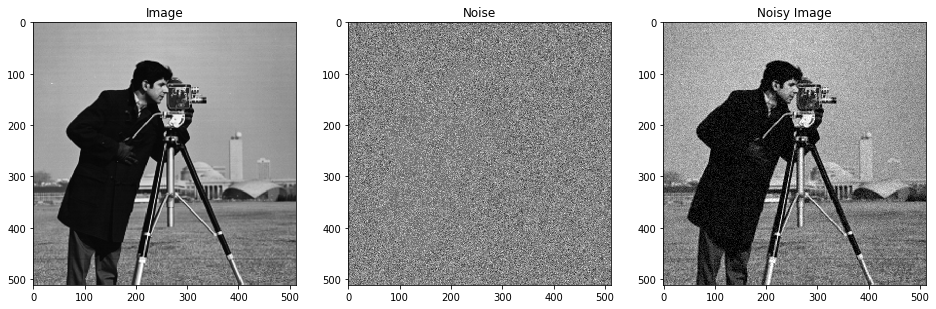

In [3]:
#plot the images
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 8))

plt.gray()

ax[0].imshow(image)
ax[0].set_title("Image")
ax[1].imshow(noise)
ax[1].set_title("Noise")
ax[2].imshow(noisy)
ax[2].set_title("Noisy Image")

plt.show()

## Wavelet Decomposition
Let us now look at the wavelet decomposition of the images and see if we can notice any patterns. Wavelets are effectively arbitrarily shaped and oriented derivative filters. An example of the Debauchie wavelet can be plotted as below. 

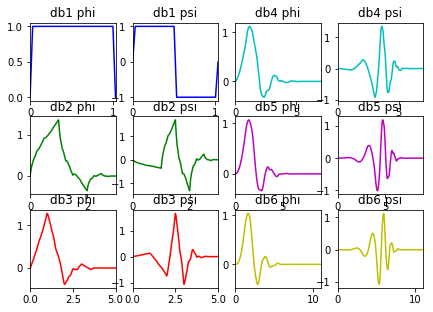

In [4]:
import itertools
import pywt

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2, bottom=.02, left=.06,
                    right=.97, top=.94)
colors = itertools.cycle('bgrcmyk')

family, (rows, cols) = 'db', (3, 2)

wnames = pywt.wavelist(family)
i = iter(wnames)
for col in range(cols):
    for row in range(rows):
        try:
            wavelet = pywt.Wavelet(next(i))
        except StopIteration:
            break
        phi, psi, x = wavelet.wavefun(level=5)

        color = next(colors)
        ax = fig.add_subplot(rows, 2 * cols, 1 + 2 * (col + row * cols))
        ax.set_title(wavelet.name + " phi")
        ax.plot(x, phi, color)
        ax.set_xlim(min(x), max(x))

        ax = fig.add_subplot(rows, 2*cols, 1 + 2*(col + row*cols) + 1)
        ax.set_title(wavelet.name + " psi")
        ax.plot(x, psi, color)
        ax.set_xlim(min(x), max(x))
plt.show()

The simplest form of these is known as the Haar wavelet, shown above in the blue as the first two plots. We will compute the discrete convolution of the image with different orientations of the wavelets. Each discrete orientation will constitute a set of wavelet coefficients, which will be interpret. This is known as the Discrete Wavelet Transform (DWT) and we will compute this for our image and obseve what happens to the distribution of the noise.

In [5]:
#Wavelet Decomposition for transform sparsity
from skimage import img_as_float

motherWavelet = 'haar'
#motherWavelet = 'db4'

wcoeffs1 = pywt.dwt2(img_as_float(image), motherWavelet)
cA, (cH, cV, cD) = wcoeffs1

meanA = np.mean(cA)
meanH = np.mean(cH)
meanV = np.mean(cV)
meanD = np.mean(cD)
print("Mean A:", meanA)
print("Mean H:", meanH)
print("Mean V:", meanV)
print("Mean D:", meanD)

('Mean A:', 0.927952964633119)
('Mean H:', -0.0013285319010416668)
('Mean V:', 0.0018830542470894603)
('Mean D:', 2.3935355392161987e-07)


In this Haar based DWT, we are computing three orientations: horizontal, vertical and diagonal. This results in 3 sets of coefficients plus the DC or average. Notice that the image sizes of the coefficients are half the size of the original image. We can actually keep repeating the proceedure on the average image to get more and more levels of the DWT. We will use a single level for this example.

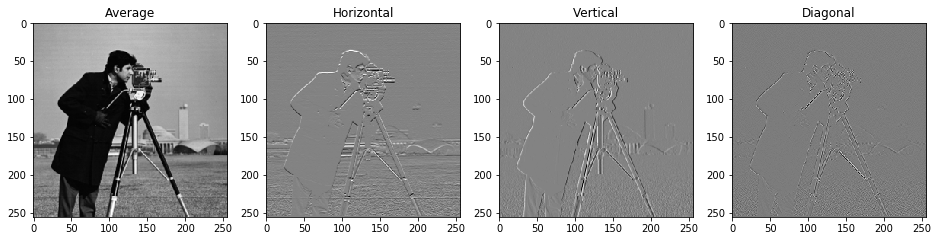

In [6]:
# plot the image coefficients
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(16, 8))

plt.gray()

ax[0].imshow(cA)
ax[0].set_title("Average")
ax[1].imshow(cH)
ax[1].set_title("Horizontal")
ax[2].imshow(cV)
ax[2].set_title("Vertical")
ax[3].imshow(cD)
ax[3].set_title("Diagonal")

plt.show()

Notice that the different orientations give different edge information at those orientations. SO that the horizontal orientations give horizontal edges etc. This is effectively additional detail at this scale. Notice that these detail images are very sparse, i.e. mostly empty. A lot of compression techniques use this to their advantage, send the average first, then the details later or discard the details.

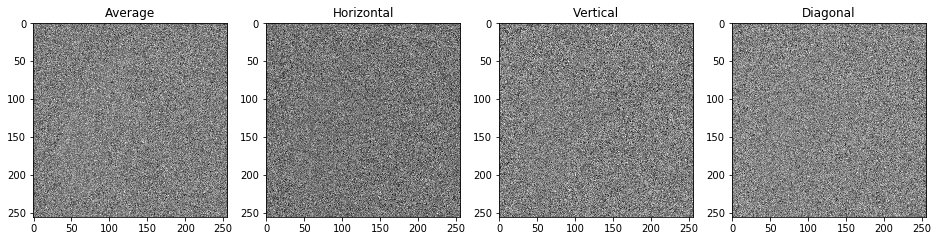

In [7]:
#noise coefficients
wcoeffs2 = pywt.dwt2(noise, motherWavelet)
cA, (cH, cV, cD) = wcoeffs2

# plot the image coefficients
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(16, 8))

plt.gray()

ax[0].imshow(cA)
ax[0].set_title("Average")
ax[1].imshow(cH)
ax[1].set_title("Horizontal")
ax[2].imshow(cV)
ax[2].set_title("Vertical")
ax[3].imshow(cD)
ax[3].set_title("Diagonal")

plt.show()

The noise however, behaves differently to the DWT. Notice that the noise is present distributed across all coefficients evenly. We will use this to our advantage. If we can just keep the "strong" details and threshold out everything else, maybe we can dampen the noise.

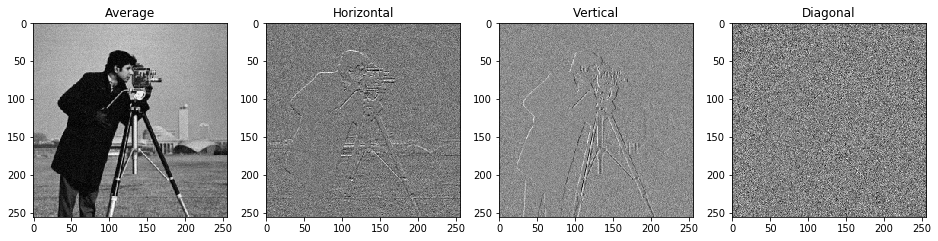

In [8]:
wcoeffs3 = pywt.dwt2(noisy, motherWavelet)
cA, (cH, cV, cD) = wcoeffs3

# plot the image coefficients
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(16, 8))

plt.gray()

ax[0].imshow(cA)
ax[0].set_title("Average")
ax[1].imshow(cH)
ax[1].set_title("Horizontal")
ax[2].imshow(cV)
ax[2].set_title("Vertical")
ax[3].imshow(cD)
ax[3].set_title("Diagonal")

plt.show()

Notice that the otherwise empty details is full of noise. Th "strong" details are still prominent, so we can threshold out the noise. But at what value?

We need to estimate the threshold value first. Let's use the median and estimate the noise sigma, then threhold the detail channels. We estimate sigma based on Donoho's (1995) formula 
$$
\sigma = \frac{\textrm{median}_d}{0.6745}
$$
for each detail channel $d$. Then the soft threshold is
$$
\lambda_d = \sigma\sqrt{2\cdot\log n}
$$
See "Signal and Image Denoising Using Wavelet Transform" by Burhan Ergen for details.

In [9]:
import numpy as np

#compute the median (use the magnitude as have negative values)
medianH = np.median(np.abs(cH))
medianV = np.median(np.abs(cV))
medianD = np.median(np.abs(cD))

meanH = np.mean(cH)
meanV = np.mean(cV)
meanD = np.mean(cD)
print("Mean H:", meanH)
print("Mean V:", meanV)
print("Mean D:", meanD)

#estimate sigma
sigmaH = medianH/0.6745
sigmaV = medianV/0.6745
sigmaD = medianD/0.6745

#estimate threshold
n = r*c
thresholdH = sigmaH*np.sqrt(2*np.log(n))
print("Threshold H:", thresholdH)
thresholdV = sigmaV*np.sqrt(2*np.log(n))
print("Threshold V:", thresholdV)
thresholdD = sigmaD*np.sqrt(2*np.log(n))
print("Threshold D:", thresholdD)

('Mean H:', -0.0010518227657951317)
('Mean V:', 0.001685256347826762)
('Mean D:', 0.00030929093565455973)
('Threshold H:', 0.26681634457020154)
('Threshold V:', 0.26830523919594557)
('Threshold D:', 0.2457735756607865)


This gives us a value to threshold each set of coefficients by and then reduce the effects of noise.

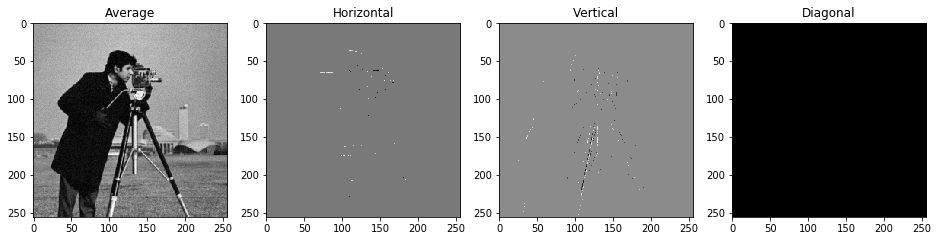

In [10]:
#threshold each detail channel
cH[ np.abs(cH) < thresholdH ] = meanH
cV[ np.abs(cV) < thresholdV ] = meanV
cD[ np.abs(cD) < thresholdD ] = meanD

# plot the image coefficients
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(16, 8))

plt.gray()

ax[0].imshow(cA)
ax[0].set_title("Average")
ax[1].imshow(cH)
ax[1].set_title("Horizontal")
ax[2].imshow(cV)
ax[2].set_title("Vertical")
ax[3].imshow(cD)
ax[3].set_title("Diagonal")

plt.show()

Finally, reconstruct the image using the processed coefficients via the inverse DWT to get the denoised image.

In [11]:
#reform coefficients
wcoeffs3 = cA, (cH, cV, cD)

denoised = pywt.idwt2(wcoeffs3, motherWavelet)

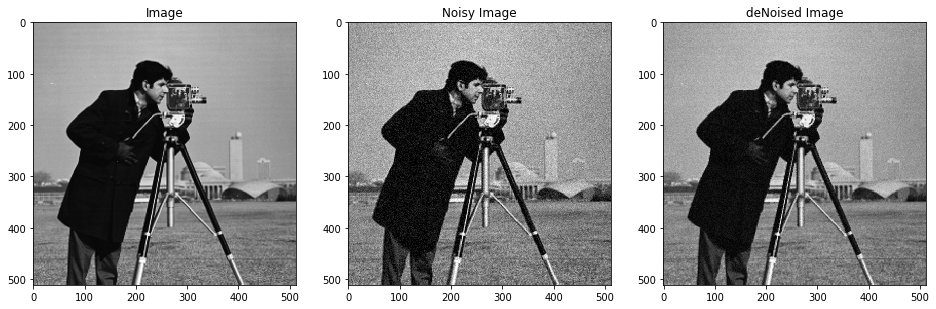

In [12]:
#plot and compare
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 8))

plt.gray()

ax[0].imshow(image)
ax[0].set_title("Image")
ax[1].imshow(noisy)
ax[1].set_title("Noisy Image")
ax[2].imshow(denoised)
ax[2].set_title("deNoised Image")

plt.show()

We need to quantify the improvement of the denoising process by comparing the result to our original uncorrupted image. We will use the Peak Signal to Noise Ratio (PSNR) and the Mean Squared Error (MSE).

In [13]:
#compute quantitiative measure of denoising effectiveness
def immse(img1, img2):
    '''
    Compute the MSE of two images
    '''
    mse = ((img1 - img2) ** 2).mean(axis=None)
    
    return mse

def impsnr(img1, img2, maxPixel=255):
    '''
    Compute the MSE of two images
    '''
    mse = immse(img1,img2)
    psnr_out = 20 * math.log(maxPixel / math.sqrt(mse), 10)
    
    return psnr_out

maxValue = image.max()
print("Noisy PSNR", impsnr(image, noisy, maxPixel=maxValue))
print("deNoised PSNR", impsnr(image, denoised, maxPixel=maxValue))

('Noisy PSNR', 26.262161327197813)
('deNoised PSNR', 29.12651962130299)


The denoised image is indeed closer to the original image. We have used a very simple soft threshold to denoise the image. We could have made it into an optimisation problem of estimating the best threshold to give the most noise removed from the detail images. This would result in a much better denoised result at the expensive of increased computational complexity.